In [ ]:
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import AveragePooling2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.layers import ZeroPadding2D
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Input
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, callbacks, models
from tensorflow.keras import layers, regularizers, activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# class ResNet9:
#     def residual_bottleneck(inputs, K, stride, reduce = False, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005):

#         shortcut = inputs

#         # the first block of the ResNet module are the 1x1 CONVs
#         bn_1 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(inputs)
#         act_1 = layers.Activation("relu")(bn_1)
#         conv_1 = layers.Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_1)

#         # the second block of the ResNet module are the 3x3 CONVs
#         bn_2 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(conv_1)
#         act_2 = layers.Activation("relu")(bn_2)
#         conv_2 = layers.Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False, 
                              #  kernel_regularizer = regularizers.l2(reg))(act_2)

#         # the third block of the ResNet module is another set of 1x1 CONVs
#         bn_3 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(conv_2)
#         act_3 = layers.Activation("relu")(bn_3)
#         conv_3 = layers.Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_3)

#         # if we are to reduce the spatial size, apply a CONV layer to
#         # the shortcut
#         if reduce:
#             shortcut = layers.Conv2D(K, (1, 1), strides = stride, use_bias = False, 
                                    #  kernel_regularizer = regularizers.l2(reg))(act_1)

#         # add together the shortcut and the final CONV
#         x = layers.add([conv_3, shortcut])

#         # return the addition as the output of the ResNet module
#         return x 
        
#     def build(input_shape, filters, stages, reg = 0.0005, bn_eps = 2e-5, bn_mom = 0.9):  

#         # input_shape = (width, height, depth)

#         # set the input and apply BN
#         inputs = layers.Input(input_shape)
#         x = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(inputs)

#         x = layers.Conv2D(filters[0], (3, 3), use_bias = False,
#                           padding = "same", kernel_regularizer = regularizers.l2(reg))(x)

#         # loop over the number of stages
#         for i in range(0, len(stages)):
#             # initialize the stride, then apply a residual module
#             # used to reduce the spatial size of the input volume
#             stride = (1, 1) if i == 0 else (2, 2)
#             x = ResNet9.residual_bottleneck(x, filters[i + 1], stride,
#                                            reduce = True, bn_eps = bn_eps, bn_mom = bn_mom)
                  
#             # loop over the number of layers in the stage
#             for j in range(0, stages[i] - 1):
#                 # apply a ResNet module
#                 x = ResNet9.residual_bottleneck(x, filters[i + 1],
#                                               (1, 1), bn_eps = bn_eps, bn_mom = bn_mom)
                      
#         # apply BN => ACT => POOL
#         x = layers.BatchNormalization(epsilon = bn_eps,
#                                       momentum = bn_mom)(x)
#         x = layers.Activation("relu")(x)
#         x = layers.AveragePooling2D((8, 8))(x)

#         # softmax classifier
#         x = layers.Flatten()(x)
#         x = layers.Dense(10, kernel_regularizer = regularizers.l2(reg))(x)
#         x = layers.Activation("softmax")(x)

#         # create the model
#         model = Model(inputs, x)

#         # return the constructed network architecture
#         return model

# # compile the model
# print("[INFO] Compiling Model...")
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, clipvalue = 0.1)  # default: lr = 0.01, mom = 0.99

# # ResNet9(input_shape), ResNet.build()
# model = ResNet9.build((32, 32, 3), (64, 64, 128, 256), (9, 9, 9), reg = 0.0005)  # (trainX.shape[1], trainX.shape[2], trainX.shape[3]) 

# model.compile(optimizer = optimizer, 
#               loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# # Advanced CNN - ResNet9 (subclassing)

# # (Cifar10 using ResNet of Kaiming He et al.)
# # ++++++++++++++++++++++++++++++++++++++++++++++ #

# '''
# Residual_Bottleneck: {(bn - relu - conv 1x1) + (bn - relu - conv 3x3) + (bn - relu - conv 1x1)} + shortcut(input) => output
#                 ###  reduce the spatial size --> apply a Conv2D layer to the shortcut  ###

# Hyperparameters: regularizer_l2(0.0001 ~ 0.0005(best)), bn_eps: 2e-5, bn_mom: 0.9, stride: 1 or 2, 
#                  filters: f = [64, 64, 128, 256], stages = (9, 9, 9)
# '''

# # ResNet9 - Subclassing 

# class Residual_bottleneck(layers.Layer):
#     def __init__(self, f, stride = 1, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005, reduce = False, **kwargs):
#         super(Residual_bottleneck, self).__init__(**kwargs)

#         self.stride = stride
#         # self.inputs = inputs

#         # step 1. (bn - relu - conv 1x1)
#         self.bn_1 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_1 = layers.Activation("relu")
#         self.conv_1 = layers.Conv2D(int(f * 0.25), (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))

#         # step 1. (bn - relu - conv 3x3)
#         self.bn_2 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_2 = layers.Activation("relu")
#         self.conv_2 = layers.Conv2D(int(f * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False, 
                                    # kernel_regularizer = regularizers.l2(reg))

#         # step 1. (bn - relu - conv 1x1)
#         self.bn_3 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_3 = layers.Activation("relu")
#         self.conv_3 = layers.Conv2D(f, (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))

#         # conv skip
#         self.bn_skip = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_skip = layers.Activation("relu")
#         self.conv_skip = layers.Conv2D(f, (1, 1), strides = stride, use_bias = False, kernel_regularizer = regularizers.l2(reg))
       
#         # reduce the spatial size
#         # self.reduce = reduce

#         # append to residual_block
#         self.residual_block = [self.bn_1, self.act_1, self.conv_1,
#                                self.bn_2, self.act_2, self.conv_2,
#                                self.bn_3, self.act_3, self.conv_3]

#         # for i in range(len(total_step)):
#         #     self.residual_block = []
#         #     self.residual_block.append(total_step[i])

#         # self.skip_block = []
#         # if stride == 2:
#         # if self.reduce:
#         self.skip_block = [self.bn_skip, self.act_skip, self.conv_skip]
      
#     def call(self, inputs):
#         x = inputs
        
#         for step in self.residual_block:
#             x = step(x)

#         shortcut = inputs
#         # apply a Conv2D layer to the shortcut
#         if self.stride == 2:
#             for skip in self.skip_block:
#                 shortcut = skip(shortcut)    #  filters ≠ int(filters * 0.25)  =>  self.conv_skip

#         output = layers.add([x, shortcut])

#         return output

#     # def get_config(self):
#     #     base_config = super().get_config()
#     #     base_config.update({
#     #         'f': self.f, 
#     #         'stride': self.stride,
#     #         'bn_eps': self.bn_eps,
#     #         'bn_mom': self.bn_mom,
#     #     })
#     #     return base_config

# class ResNet9(Model):
#     def __init__(self, inputs, filters, stages, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005, pooling_size = (8, 8), **kwargs):
#         super(ResNet9, self).__init__(**kwargs)

#         self.filters = filters
#         self.stages = stages
#         self.bn_eps = bn_eps
#         self.bn_mom = bn_mom
#         self.reg = reg

#         self.inputs = layers.Input(inputs)

#         self.bn = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.conv2d = layers.Conv2D(filters[0], (3, 3), padding = 'same', use_bias = False, 
                                   #  kernel_regularizer = regularizers.L2(reg))

#         self.act = layers.Activation('relu')
#         self.avg_pool2d = layers.AveragePooling2D(pooling_size)

#         self.flatten = layers.Flatten()
#         self.dense = layers.Dense(10, kernel_regularizer = regularizers.L2(reg))

#     def call(self, inputs):

#         # hint:
#         # stage[0] -> filters[1] * 9 (stride = 1)
#         # stage[1] -> filters[2] * 1 (stride = 2) + filters[2] * 8 (stride = 1)
#         # stage[2] -> filters[3] * 1 (stride = 3) + filters[3] * 8 (stride = 1)
#         # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

#         x = self.bn(self.inputs)
#         x = self.conv2d(x)

#         # for s in range(0, len(self.stages)):
#         #     stride = 1 if s == 0 else 2
#         #     x = Residual_bottleneck(self.filters[s + 1], stride, bn_eps = self.bn_eps, 
#         #                         bn_mom = self.bn_mom, reg = self.reg, reduce = True)(x)
#         #     for i in range(0, self.stages[s] - 1):
#         #         x = Residual_bottleneck(self.filters[s + 1], (1, 1), bn_eps = self.bn_eps,
#         #                             bn_mom = self.bn_mom, reg = self.reg)(x)

#         # loop over the number of stages
#         prev_filters = self.filters[1]
#         s1, s2, s3 = self.stages

#         for i in [self.filters[1]] * s1 + [self.filters[2]] * s2 + [self.filters[3]] * s3:
#             stride = 1 if i == prev_filters else 2
#             x = Residual_bottleneck(i, stride, bn_eps = self.bn_eps, bn_mom = self.bn_mom)(x)
#             prev_filters = i

#         # bn -> act -> pool
#         x = self.bn(x)
#         x = self.act(x)
#         x = self.avg_pool2D(x)

#         # flatten -> dense -> softmax
#         x = self.flatten()(x)
#         x = self.dense(x)
#         x = self.act('softmax')(x)

#         return x

# compile the model
print("[INFO] Compiling Model...")
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, clipvalue = 0.1)  # default: lr = 0.01, mom = 0.99

# model = ResNet9((32, 32, 3), (64, 64, 128, 256), (9, 9, 9), reg = 0.0005)

# model.compile(optimizer = optimizer, 
#               loss = 'categorical_crossentropy', metrics = ['accuracy'])

[INFO] Compiling Model...


In [ ]:
# ResNet9 - Subclassing 

class ResNet9:
    def Residual_bottleneck(inputs, f, stride = 1, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005):
        
        # step 1. (bn - relu - conv 1x1)
        bn_1 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(inputs)
        act_1 = layers.Activation("relu")(bn_1)
        conv_1 = layers.Conv2D(int(f * 0.25), (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_1)

        # step 2. (bn - relu - conv 3x3)
        bn_2 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(conv_1)
        act_2 = layers.Activation("relu")(bn_1)
        conv_2 = layers.Conv2D(int(f * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False, 
                               kernel_regularizer = regularizers.l2(reg))(act_2)

        # step 3. (bn - relu - conv 1x1)
        bn_3 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(conv_2)
        act_3 = layers.Activation("relu")(bn_3)
        conv_3 = layers.Conv2D(f, (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_3)

        # conv skip
        conv_skip = layers.Conv2D(f, (1, 1), strides = stride, use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_1)

        shortcut = inputs
        if stride == 2:
            shortcut = conv_skip
      
        output = layers.add([conv_3, shortcut])

        return output

    def call(inputs, filters, stages, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005, pooling_size = (8, 8)):

        input = layers.Input(inputs)
        x = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(input)
        x = layers.Conv2D(filters[0], (3, 3), padding = 'same', use_bias = False, kernel_regularizer = regularizers.L2(reg))(x)
        
        # hint:
        # stage[0] -> filters[1] * 9 (stride = 1)
        # stage[1] -> filters[2] * 1 (stride = 2) + filters[2] * 8 (stride = 1)
        # stage[2] -> filters[3] * 1 (stride = 2) + filters[3] * 8 (stride = 1)
        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        
        # for s in range(0, len(stages)):
        #     stride = 1 if s == 0 else 2
        #     x = ResNet9.Residual_bottleneck(x, filters[s + 1], stride, bn_eps = bn_eps, 
        #                                     bn_mom = bn_mom, reduce = True)
        #     for i in range(0, stages[s] - 1):
        #         x = ResNet9.Residual_bottleneck(x, filters[s + 1], (1, 1), bn_eps = bn_eps,
        #                                         bn_mom = bn_mom)

        # loop over the number of stages
        prev_filters = filters[1]
        s1, s2, s3 = stages

        for i in [filters[1]] * s1 + [filters[2]] * s2 + [filters[3]] * s3:
            stride = 1 if i == prev_filters else 2
            x = ResNet9.Residual_bottleneck(x, i, stride, bn_eps = bn_eps, bn_mom = bn_mom)
            prev_filters = i

        # bn -> act -> pool
        x = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(x)
        x = layers.Activation('relu')(x)
        x = layers.AveragePooling2D(pooling_size)(x)

        # flatten -> dense -> softmax
        x = layers.Flatten()(x)
        x = layers.Dense(10, kernel_regularizer = regularizers.L2(reg))(x)
        x = layers.Activation('softmax')(x)

        model = Model(input, x)

        return model

# compile the model
print("[INFO] Compiling Model...")
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, clipvalue = 0.1)  # default: lr = 0.01, mom = 0.99  # decay

model = ResNet9.call((32, 32, 3), (64, 64, 128, 256), (9, 9, 9), reg = 0.0005)

model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

[INFO] Compiling Model...


In [ ]:
# # ResNet-34 subclassing

# class ResidualUnit(layers.Layer):
#     def __init__(self, f, stride = 1, activation = 'relu', **kwargs):
#         super(ResidualUnit, self).__init__()
        
#         self.f = f
#         self.stride = stride
#         self.activation = activations.get(activation)

#         self.res_block = [
#                 layers.Conv2D(f, 3, strides = stride, padding = 'same', use_bias = False),
#                 layers.BatchNormalization(),
#                 layers.Conv2D(f, 3, strides = 1, padding = 'same', use_bias = False),
#                 layers.BatchNormalization()]

#         self.skip_block = []
#         if stride > 1:
#             self.skip_block = [
#                     layers.Conv2D(f, 1, strides = stride, padding = 'same', use_bias = False),
#                     layers.BatchNormalization()]

#     def call(self, inputs):
#         x = inputs
#         for step in self.res_block:
#             x = step(x)

#         shortcut = inputs
#         for skip in self.skip_block:
#             shortcut = skip(shortcut)
        
#         return self.activation(x + shortcut)

#     def get_config(self):
#         base_config = super().get_config()
#         base_config.update({
#             'f': self.f, 
#             'stride': self.stride,
#             'activations': self.activation
#         })
#         return base_config

# # build model
# model = models.Sequential()
# model.add(layers.Conv2D(64, 7, strides = 2, input_shape = [32, 32, 3], padding = "same", use_bias = False))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same"))

# prev_filters = 64
# for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
#     stride = 1 if filters == prev_filters else 2
#     model.add(ResidualUnit(filters, stride))
#     prev_filters = filters

# model.add(layers.GlobalAvgPool2D())
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation = 'softmax'))

# compile the model
print("[INFO] Compiling Model...")
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, decay = 0.0005, clipvalue = 0.1)  # default: lr = 0.01, mom = 0.99

# # model = ResNet34((32, 32, 3))

# model.compile(optimizer = optimizer, 
#               loss = 'categorical_crossentropy', metrics = ['accuracy'])

[INFO] Compiling Model...


In [ ]:
class CyclicalLR(callbacks.Callback):
    def __init__(self, init_lr, max_lr, step_size, gamma = 0.99994, mode = 'triangular2'):
        super(CyclicalLR, self).__init__()
        self.init_lr, self.max_lr = init_lr, max_lr
        self.step_size = step_size
        self.gamma = gamma
        self.mode = mode

        self.cycle_iter = 0
        self.cycle_state = False
        self.reset() 

        if self.mode == 'triangular2':
            self.scale_fn = lambda x: 1 / (2.0**(x - 1))
            self.cycle_state = True
        elif self.mode == 'exp_range':
            self.scale_fn = lambda x: gamma ** x
            self.cycle_state = True
        elif self.mode == 'triangular':
            self.scale_fn = lambda x: 1

    # def reset(self):
    #     self.cycle_iter = 0

    def cycle_lr(self):
        cycle = tf.floor(1 + self.cycle_iter / (2 * self.step_size))
        x = tf.abs(self.cycle_iter / self.step_size - 2 * cycle + 1)
        if self.cycle_state == True:
            return self.init_lr + (self.max_lr - self.init_lr) * tf.maximum(tf.cast(0, tf.float32), (1 - x)) * self.scale_fn(cycle)
        else:
            return self.init_lr + (self.max_lr - self.init_lr) * tf.maximum(tf.cast(0, tf.float32), (1 - x)) * self.scale_fn()

    def on_train_begin(self, logs = None):

        if self.cycle_iter == 0:
            K.set_value(self.model.optimizer.lr, self.init_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.cycle_lr())

    def on_batch_end(self, epoch, logs = None):

        self.cycle_iter += 1
        K.set_value(self.model.optimizer.lr, self.cycle_lr())

    def on_epoch_end(self, epoch, logs = None):

        logs_ratio = logs['val_loss'] / logs['loss']
        print(f'\nval/train_ratio: {logs_ratio:.2f}')

In [ ]:
# model.summary()

In [ ]:
import os 

DRIVE = '/content/drive/MyDrive/'

ML_PATH = "大伯 - ML_Code/"

if os.path.isdir(os.path.join(DRIVE, 'Colab Notebooks/')):
    MODEL_PATH = os.path.join(DRIVE, 'Colab Notebooks/', ML_PATH)   # drive_1
else:
    MODEL_PATH = os.path.join(DRIVE, ML_PATH)                       # drive_2

os.listdir(MODEL_PATH)

In [ ]:
# Learning_rate_decay

def lr_decay(epoch):
    base_lr = 1e-1   # ResNet9: 0.1
    pow = 1.0
    lr_decay = base_lr * (1 - epoch/EPOCHS)**pow  -->  # used by SGD 

    return lr_decay

In [ ]:
print("[INFO] loading CIFAR-10 datasets...")
(train_X, train_Y), (test_X, test_Y) = datasets.cifar10.load_data()   # train: (50000, 32, 32, 3), (50000, 1)
  

# Normalize pixel values to be between 0 and 1
print("[INFO] Rescaling and Centered data...")
train_X_norm, test_X_norm = train_X.astype('float32')/255.0, test_X.astype('float32')/255.0


# Zero-Centered
mean = np.mean(train_X_norm, axis = 0)
train_X_norm -= mean
test_X_norm -= mean


# One_Hot_Encode Transform (convert the labels from integer to vector)
train_Y_onehot = to_categorical(train_Y, 10)
test_Y_onehot = to_categorical(test_Y, 10)


# Construct the image generator for Data Augmentation
print("[INFO] Using Data Augmentation...")
data_aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, 
                                  horizontal_flip = True)   # rotation_range = 10


# best_weights path
best_weights_path = os.path.join(model_path, "best_cifar10_weights.h5")


# Hyperparameters: 
# +++++++++++++++++++ #
EPOCHS = 100
INIT_LR = 1e-1
Batch_Size = 128   # 32, 64, 128, 256
Patience = 30
print(f"[INFO] Hyperparameters: EPOCHS = {EPOCHS}, Batch_Size = {Batch_Size}, Patience = {Patience}...")


# Learning_rate_decay
lr_decay = callbacks.LearningRateScheduler(lr_decay)


# Performance Scheduling
performance_scheduler = callbacks.ReduceLROnPlateau(factor = 0.3, patience = 5, min_lr = 0.5e-6)   # factor = 0.3


# OneCycle policy
# one_cycle = CyclicalLR(init_lr = 0.01, max_lr = 0.1, step_size = math.ceil(8 * len(trainX) / Batch_Size),
                    #    mode = 'triangular2')    # gamma = 0.99994, mode = 'triangular', 'triangular2', 'exp_range'


check_point = callbacks.ModelCheckpoint(best_weights_path, save_best_only = True)   # default_param: monitor = 'val_loss'
early_stop = callbacks.EarlyStopping(patience = Patience, restore_best_weights = True)

callbacks = [check_point, early_stop, lr_decay] 

print("[INFO] Setup ModelCheckpoint, EarlyStopping, LearningRate_Schedule...")

[INFO] loading CIFAR-10 datasets...
170500096/170498071 [==============================] - 6s 0us/step
[INFO] Rescaling and Centered data...
[INFO] Using Data Augmentation...
[INFO] Hyperparameters: EPOCHS = 100, Batch_Size = 128, Patience = 30...
[INFO] Setup ModelCheckpoint, EarlyStopping, LearningRate_Schedule...


In [ ]:
# Golab GPU devices status

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
! nvidia-smi 

Num GPUs Available:  1
Fri Jul  9 08:43:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    69W / 149W |    136MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [ ]:
# Reload the best_weights to evaluate  or  add more epochs to train

# best_weights_path = os.path.join(model_path, "best_cifar10_weights.h5")
# model = models.load_model(best_weights_path)

In [ ]:
 # Train the network

print("[INFO] Training Network...")
history = model.fit(data_aug.flow(train_X_norm, train_Y_onehot, Batch_Size),
          validation_data = (test_X_norm, test_Y_onehot),
          steps_per_epoch = len(train_X) // Batch_Size, epochs = EPOCHS,
          callbacks = callbacks, verbose = 1) 

[INFO] Training Network...
Epoch 1/100
390/390 [==============================] - 75s 175ms/step - loss: 3.2367 - accuracy: 0.4280 - val_loss: 2.9882 - val_accuracy: 0.4981


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
390/390 [==============================] - 67s 171ms/step - loss: 2.7238 - accuracy: 0.5846 - val_loss: 2.6181 - val_accuracy: 0.5990
Epoch 3/100
390/390 [==============================] - 67s 171ms/step - loss: 2.4120 - accuracy: 0.6638 - val_loss: 2.4574 - val_accuracy: 0.6427
Epoch 4/100
390/390 [==============================] - 67s 171ms/step - loss: 2.1698 - accuracy: 0.7197 - val_loss: 2.1387 - val_accuracy: 0.7214
Epoch 5/100
390/390 [==============================] - 67s 171ms/step - loss: 1.9850 - accuracy: 0.7565 - val_loss: 2.1438 - val_accuracy: 0.7021
Epoch 6/100
390/390 [==============================] - 67s 171ms/step - loss: 1.8296 - accuracy: 0.7844 - val_loss: 1.9676 - val_accuracy: 0.7389
Epoch 7/100
390/390 [==============================] - 67s 171ms/step - loss: 1.7027 - accuracy: 0.8043 - val_loss: 1.7976 - val_accuracy: 0.7709
Epoch 8/100
390/390 [==============================] - 67s 171ms/step - loss: 1.5947 - accuracy: 0.8195 - val_loss: 1.8068 -

In [ ]:
print(history.history.keys())
print(history.params)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
{'verbose': 1, 'epochs': 100, 'steps': 390}


In [ ]:
print("[INFO] Save Model History...")
import json

# Save Metric and the Loss for each epoch
history_dict = history.history

json.dump(str(history_dict), open(MODEL_PATH + 'model_weights/history/' + 'history.json', 'w'))

for i in range(5):
    loss_num = history_dict["loss"][-5:][i]
    if i == 4:
        print(f'last history["loss"] -> {i}: {loss_num:.4f}' + ' --> last loss !')
    else:
        print(f'last history["loss"] -> {i}: {loss_num:.4f}')

[INFO] Save Model History...
last history["loss"] -> 0: 0.1732
last history["loss"] -> 1: 0.1721
last history["loss"] -> 2: 0.1719
last history["loss"] -> 3: 0.1710
last history["loss"] -> 4: 0.1703 --> last loss !


In [ ]:
print("[INFO] Predict Model...")
test_loss, test_acc = model.evaluate(test_X_norm, test_Y_onehot, verbose=2)

print(f'test_loss: {test_loss:.4f}')
print(f'test_acc: {test_acc:.4f}')

[INFO] Predict Model...
313/313 - 4s - loss: 0.4490 - accuracy: 0.9332
test_loss: 0.4490
test_acc: 0.9332


[INFO] Predict Model Curves...


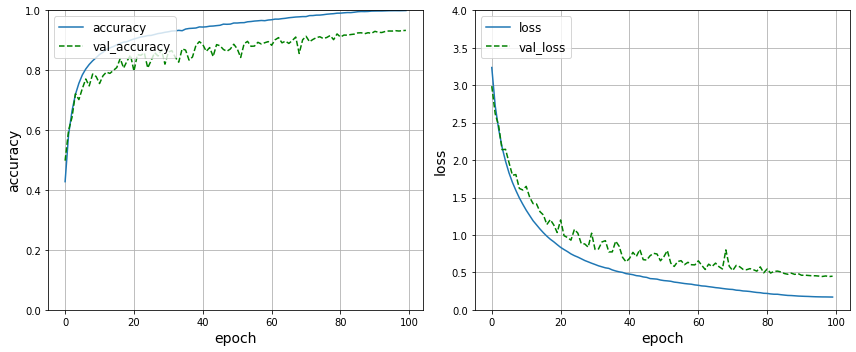

save figure:  ResNet9_128_batch_acc_0.9332_fig
313/313 - 4s - loss: 0.4490 - accuracy: 0.9332
predict done
test_loss: 0.4490
test_acc: 0.9332


In [ ]:
# Evaluate the model

import matplotlib.pyplot as plt

acc_loss_fig = 'ResNet9_128_batch_acc_0.9332_fig'   

def plot_model_pred_curves(figsize):
    fig, ax = plt.subplots(ncols = 2, sharex = True, figsize = figsize)

    for i in list(range(2)):
        plt.axes(ax[i])
        if i == 0:
            acc_loss, val_acc_loss, ylim = ('accuracy', 'val_accuracy', 1)
        if i == 1:
            loss_ylim = np.ceil(np.maximum(np.max(history.history['loss']), np.max(history.history['val_loss'])))
            acc_loss, val_acc_loss, ylim = ('loss', 'val_loss', loss_ylim)

        plt.plot(history.history[ acc_loss ], label = acc_loss)
        plt.plot(history.history[ val_acc_loss ], "g--", label = val_acc_loss)
        plt.xlabel('epoch', fontsize = 14)
        plt.ylabel(acc_loss, fontsize = 14)
        plt.ylim(0, ylim)
        plt.grid(True)
        plt.legend(loc='upper left', fontsize = 12)
        plt.tight_layout()
    plt.show()

    fig.savefig(MODEL_PATH + acc_loss_fig + '.png', format = 'png', dpi = 300)   # model_path = os.path.join(os.getcwd(), cifar_path)
    print('save figure: ', acc_loss_fig)

print("[INFO] Predict Model Curves...")
plot_model_pred_curves(figsize = (12, 5))
 
# print test_loss, test_acc
test_loss, test_acc = model.evaluate(test_X_norm, test_Y_onehot, verbose=2)

print("predict done")
print(f'test_loss: {test_loss:.4f}')
print(f'test_acc: {test_acc:.4f}')

In [ ]:
# Save configure

model_name = 'cifar10_ResNet9_acc_0.9332'     
model_dir = 'model_weights/'

def save_model(model_name, model_dir, model_path):     # model_path = os.path.join(os.getcwd(), cifar_path)
    model_json = model.to_json()

    with open(model_path + model_dir + model_name + ".config","w") as json_file:
        json_file.write(model_json)
    print("save " + model_name + ".config")

    model.save_weights(model_path + model_dir + model_name + ".h5")
    print("save " + model_name + ".h5")

print("[INFO] Save Model...")
save_model(model_name, model_dir, MODEL_PATH)

[INFO] Save Model...
save cifar10_ResNet9_acc_0.9332.config


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


save cifar10_ResNet9_acc_0.9332.h5


In [ ]:
# Loaded model

model_name = 'cifar10_ResNet9_acc_0.9332'     
model_dir = 'model_weights/'

def load_model(model_name, model_dir, model_path):      # model_path = os.path.join(os.getcwd(), cifar_path)
    json_file = open(model_path + model_dir + model_name + ".config", "r")
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = models.model_from_json(loaded_model_json)
    loaded_model.load_weights(model_path + model_dir + model_name + ".h5")
    print("[INFO] Loaded Model configure & weights...")

    return loaded_model

loaded_model = load_model(model_name, model_dir, MODEL_PATH)

[INFO] Loaded Model configure & weights...


In [ ]:
# Re Compile & Evaluate

print("[INFO] Compiling Model...")
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, clipvalue = 0.1)  # default: lr = 0.01, mom = 0.99  # decay
loaded_model.compile(optimizer = optimizer,
                     loss = 'categorical_crossentropy', metrics = ['accuracy']) 

print("[INFO] Predict Model...")
test_loss, test_acc = loaded_model.evaluate(test_X_norm, test_Y_onehot, verbose=2)
print(f'test_loss: {test_loss:.4f}')
print(f'test_acc: {test_acc:.4f}')

[INFO] Compiling Model...
[INFO] Predict Model...
313/313 - 42s - loss: 0.4490 - accuracy: 0.9332
test_loss: 0.4490
test_acc: 0.9332


In [ ]:
# Set cifar10 class names
class_value = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num = [i for i in range(10)]

class_names = { key: class_value[key] for key in num }
print(class_names)


# Test_X prediction
y_prob = loaded_model.predict(test_X_norm)
print(f"instance 1 prediction: \n", y_prob[:1])

# Test_X class prediction
max_num = 50
class_pred = y_prob.argmax(axis = -1)
print(f"top {max_num} classes: \n", class_pred[:max_num])

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
instance 1 prediction: 
 [[1.3375899e-10 3.5040911e-11 6.9334503e-11 1.0000000e+00 5.6726204e-11
  4.1875938e-09 7.6367268e-10 2.3256022e-11 2.8159333e-11 4.7764037e-12]]
top 50 classes: 
 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6]


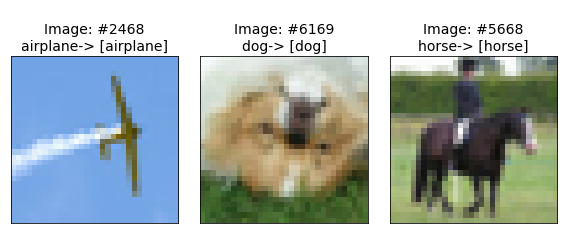


Image: #2468

airplane     99.97%
bird         0.0283364439%
ship         0.0005470290%
automobile   0.0002152251%
cat          0.0002085098%


Image: #6169

dog          99.66%
deer         0.3363318974%
cat          0.0028525108%
frog         0.0001503263%
bird         0.0001033885%


Image: #5668

horse        100.00%
bird         0.0000041874%
dog          0.0000023824%
automobile   0.0000016851%
truck        0.0000009119%



In [ ]:
import matplotlib.pyplot as plt 

# Plot random number cifar10 img
top_K = 5
num_img = 3

plt.figure(figsize = (8, 5), tight_layout = True)

# rand_n = [random.randint(0, len(test_X)) for _ in range(num_img)]
rand_n = np.random.choice(len(test_X), num_img) 

for i in range(num_img):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_X[rand_n[i]])

    img_title = f"\nImage: #{rand_n[i]}\n"
    title = class_names[test_Y[rand_n[i]][0]]
    pred_name = '-> [' + class_names[class_pred[rand_n[i]]] + ']'

    if class_names[class_pred[rand_n[i]]] != title:
        plt.xlabel("incorrect !", fontsize = 14, fontdict = {'color': 'red'})
    plt.title(img_title + title + pred_name, fontsize = 14)

plt.show()


# Visualize top_K  {class_name}  and  {y_pred} 
for n in range(num_img):
    for k in range(1, top_K + 1):
        pred = np.sort(y_prob[rand_n[n]])[-k:][::-1]
        name = class_names[np.argsort(y_prob[rand_n[n]])[-k:][::-1][k-1]]
        if k == 1:
            print(f"\nImage: #{rand_n[n]}\n")
            print(f"{name:12s} {pred[k-1] * 100:.2f}%")
        else:
            print(f"{name:12s} {pred[k-1] * 100:.10f}%")
    print()